##### Master Degree in Computer Science and Data Science for Economics

# Example of a naive search engine

### Alfio Ferrara

In [1]:
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer
import pymongo
import pandas as pd

## A toy example

In [2]:
from nlp.textgen import ConditionalTextGenerator
import numpy as np 

In [3]:
vocab = ["sunny", "cloudy", "rain", "snow", "windy"]
gen = ConditionalTextGenerator(vocab, order=2, mix=0.9)

gen.base_unigram = gen._normalize_dist(gen.base_unigram)

# Rules: P(next | context)
gen.set_rule(("sunny",),  {"sunny":0.55, "cloudy":0.30, "windy":0.10, "rain":0.04, "snow":0.01})
gen.set_rule(("cloudy",), {"cloudy":0.45, "rain":0.25, "sunny":0.20, "windy":0.08, "snow":0.02})
gen.set_rule(("rain",),   {"rain":0.50, "cloudy":0.35, "windy":0.10, "sunny":0.04, "snow":0.01})
gen.set_rule(("snow",),   {"snow":0.50, "cloudy":0.35, "windy":0.10, "sunny":0.03, "rain":0.02})
gen.set_rule(("windy",),  {"windy":0.30, "cloudy":0.35, "sunny":0.15, "rain":0.15, "snow":0.05})
gen.set_rule(("sunny","windy"),  {"sunny":0.50, "cloudy":0.25, "windy":0.20, "rain":0.05})
gen.set_rule(("cloudy","windy"), {"cloudy":0.45, "rain":0.30, "windy":0.15, "sunny":0.10})
gen.set_rule(("windy","sunny"),  {"sunny":0.55, "cloudy":0.20, "windy":0.20, "rain":0.05})
gen.set_rule(("windy","rain"),   {"rain":0.55, "cloudy":0.25, "windy":0.15, "sunny":0.05})

docs = [" ".join(gen.generate(x, start_context=np.random.choice(vocab))) for x in np.random.randint(7, 50, size=200)]

In [4]:
docs[0]

'rain rain cloudy cloudy cloudy cloudy sunny sunny sunny cloudy sunny sunny cloudy'

### Indexing

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

In [6]:

wtokenizer = lambda x: x.split()
vectorizer = CountVectorizer(tokenizer=wtokenizer, token_pattern=None)
W = vectorizer.fit_transform(docs).toarray()
Wdf = pd.DataFrame(W, columns=vectorizer.get_feature_names_out())

Wdf.head()

,cloudy,rain,snow,sunny,windy
0,6,2,0,5,0
1,5,3,0,18,4
2,9,5,0,19,8
3,11,3,2,4,1
4,9,2,7,8,0


### Vector space

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

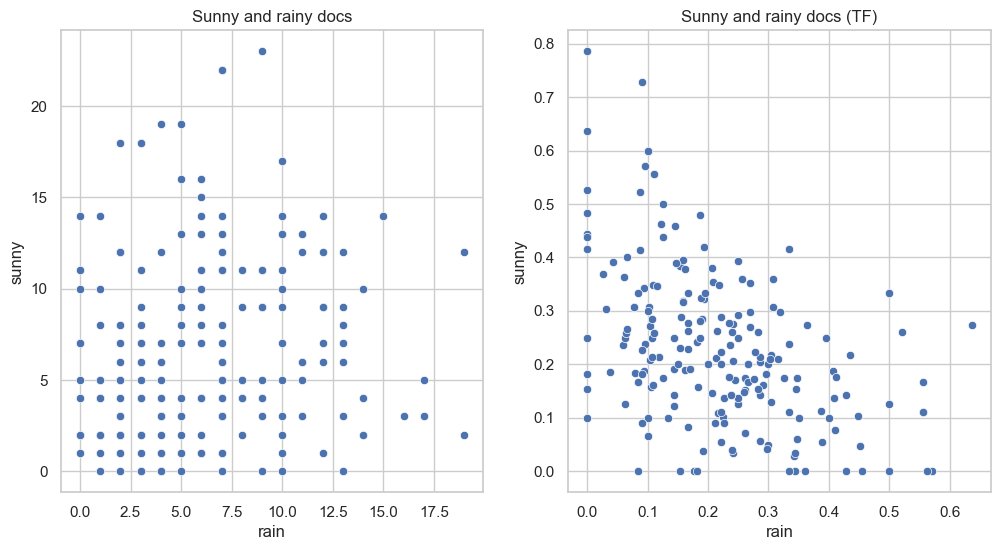

In [8]:
sns.set(style="whitegrid") 

TFW = (Wdf.T / Wdf.sum(axis=1)).T

fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
sns.scatterplot(data=Wdf, x="rain", y="sunny", ax=ax[0])
sns.scatterplot(data=TFW, x="rain", y="sunny", ax=ax[1])
ax[0].set_title("Sunny and rainy docs")
ax[0].set_xlabel("rain")
ax[0].set_ylabel("sunny")
ax[1].set_title("Sunny and rainy docs (TF)")
ax[1].set_xlabel("rain")
ax[1].set_ylabel("sunny")
plt.show()

### Visualize docs per main type

In [9]:
from collections import Counter
from sklearn.manifold import TSNE

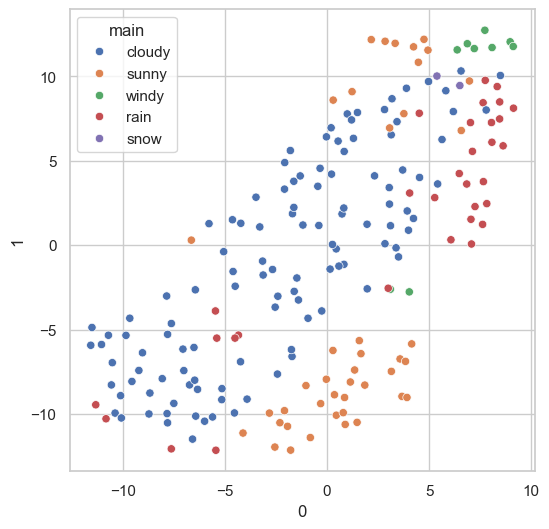

In [10]:
labels = [vocab.index(Counter(doc.split()).most_common(1)[0][0]) for doc in docs]
W2 = pd.DataFrame(TSNE(n_components=2).fit_transform(Wdf))
W2['main'] = [vocab[i] for i in labels]
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=W2, x=0, y=1, hue='main', ax=ax)
plt.show()


## Real data

In [11]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [12]:
db = pymongo.MongoClient()['cousine']
collection = db['recipes']
docs = []
for evidence in collection.find():
    # claim = evidence['claim']
    # article = evidence['article']
    text = evidence['instructions']
    #docs.append(". ".join([claim, article, text]))
    docs.append(text)

In [13]:
docs[0]

'To begin making the Roasted Peppers And Mushroom Tortilla Pizza recipe, turn your oven setting to broiler and keep it ready.|Grease your cast iron skillet with some olive oil and heat it over high heat.|When it starts to shimmer bring down the heat to medium. Add olive oil and minced garlic to the marinara sauce and stir to combine, keep aside.|Place one tortilla on the cast iron skillet. Spread a thin layer of marinara sauce over the tortilla.|Spread the cheese as needed. When the cheese starts to melt, add in the toppings which includes onion, mushrooms, olives and bell peppers.|Now shift the cast iron skillet to the oven which is already under broiler setting.|When you see the cheese all melted and top starting to brown, remove and slice to serve.|Serve Roasted Peppers And Mushroom Tortilla Pizza along with | and | for a weekend night dinner.'

## Indexing

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def bert_tokenize(text):
    return tokenizer.tokenize(text)

In [ ]:
vectorizer = CountVectorizer(tokenizer=bert_tokenize, token_pattern=None)
X = vectorizer.fit_transform(docs).toarray()

In [ ]:
Xdf = pd.DataFrame(X, columns=vectorizer.get_feature_names_out())

In [ ]:
Xdf 

In [ ]:
docs[0]

In [ ]:
Xdf.loc[0].sort_values(ascending=False).head(10)

## Search

In [ ]:
query = "Extinction of animals"
q = vectorizer.transform([query]).toarray().reshape(1, -1)
q 

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
sigma = cosine_similarity(q, X)
sigma.shape 

In [ ]:
query_answer = pd.Series(sigma[0], index=range(len(docs)))
A = query_answer.sort_values(ascending=False).head(10)

In [ ]:
from nltk.tokenize import sent_tokenize

In [ ]:
def pretty_print(doc):
    return "\n".join([s for s in sent_tokenize(doc)])

In [ ]:
for i, s in A.items():
    print(f"Document {i} with similarity {s}")
    print(pretty_print(docs[i]))
    print()

## IDF

In [ ]:
from collections import defaultdict

In [ ]:
DF = defaultdict(lambda: 0)
for doc in docs:
    tokens = set(bert_tokenize(doc))
    for token in tokens:
        DF[token] += 1
DF = pd.Series(DF)

In [ ]:
DF.sort_values(ascending=False)
IDF = len(docs) / DF 
IDF.sort_values(ascending=True)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3), ncols=2)
ax[0].plot(IDF.sort_values(ascending=False).values)
ax[1].plot(np.log(IDF.sort_values(ascending=False).values))
plt.tight_layout()
plt.show()

## TFIDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfv = TfidfVectorizer(tokenizer=bert_tokenize, token_pattern=None)

In [ ]:
Xtfidf = tfv.fit_transform(docs).toarray()
TFIDF = pd.DataFrame(Xtfidf, columns=tfv.get_feature_names_out())

In [ ]:
TFIDF

In [ ]:
TFIDF.loc[0].sort_values(ascending=False).head(10)